# Customer Segmentation Profiling

This notebook focuses on the **interpretation and profiling** of the customer segments identified in the previous clustering step. We will analyze the characteristics of each cluster to derive actionable business insights and define customer personas.

**Objectives**
- Analyze the distribution of customers across clusters.
- Compare clusters based on key features (RFM, Product Diversity, etc.).
- Perform statistical tests to validate the differences between segments.
- Define clear personas for each cluster (e.g., "Loyal Champions", "At-Risk").
- Export the final profiles for reporting and marketing activation.

## 1. Setup & Data Loading

We load the processed dataset (scaled features), the final cluster labels, and the scaler object to reconstruct the original feature values for meaningful interpretation.

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from scipy.stats import kruskal

sns.set_style("whitegrid")

# Paths
PROCESSED_DIR = Path('../data/processed')
MODELS_DIR = Path('../models')
IMAGES_DIR = Path('../images')

# Load Data
customers_scaled = pd.read_csv(PROCESSED_DIR / 'customers_final.csv')
clusters = pd.read_csv(PROCESSED_DIR / 'clusters_FINAL.csv')

# Load Scaler
with open(MODELS_DIR / 'scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

def save_fig(name):
    plt.savefig(IMAGES_DIR / f"{name}.png", dpi=300, bbox_inches='tight')

### 1.1 Reconstruct Original Features

Since the clustering was performed on scaled data, we inverse transform the features to interpret them in their original units (e.g., monetary value in currency, recency in days).

In [38]:
# Separate ID and features
feature_cols = [c for c in customers_scaled.columns if c != 'CustomerID']
X_scaled = customers_scaled[feature_cols]

# Inverse transform
X_original = scaler.inverse_transform(X_scaled)
df_original = pd.DataFrame(X_original, columns=feature_cols)
df_original['CustomerID'] = customers_scaled['CustomerID']

# Merge with Cluster Labels
df_final = df_original.merge(clusters[['CustomerID', 'Cluster']], on='CustomerID', how='inner')

country_cols = [c for c in df_final.columns if c.startswith("Country_")]
df_final[country_cols] = (df_final[country_cols] > 0.5).astype(int)

print(f"Final dataset shape: {df_final.shape}")
df_final.head()

Final dataset shape: (5878, 49)


,Frequency,Monetary,Recency,Country_Australia,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,...,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,Country_West Indies,AvgBasketValue,BasketValueVariance,DistinctProducts,CustomerID,Cluster
0,12.0,77556.46,326.0,0,0,0,0,0,0,0,...,0,0,1,0,0,6463.038333,4.546737e+08,27.0,12346.0,0
1,8.0,4921.53,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,615.191250,8.724888e+04,126.0,12347.0,1
2,5.0,2019.40,75.0,0,0,0,0,0,0,0,...,0,0,0,0,0,403.880000,6.267392e+04,25.0,12348.0,0
3,4.0,4428.69,19.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1107.172500,3.336840e+05,138.0,12349.0,1
4,1.0,334.40,310.0,0,0,0,0,0,0,0,...,0,0,0,0,0,334.400000,3.259629e-09,17.0,12350.0,0


## 2. Basic Cluster Sanity Checks

We start by checking the size of each cluster to ensure we have meaningful segments and not just noise.

Cluster Counts:
Cluster
0    2082
1    3549
2     152
3      95
Name: count, dtype: int64


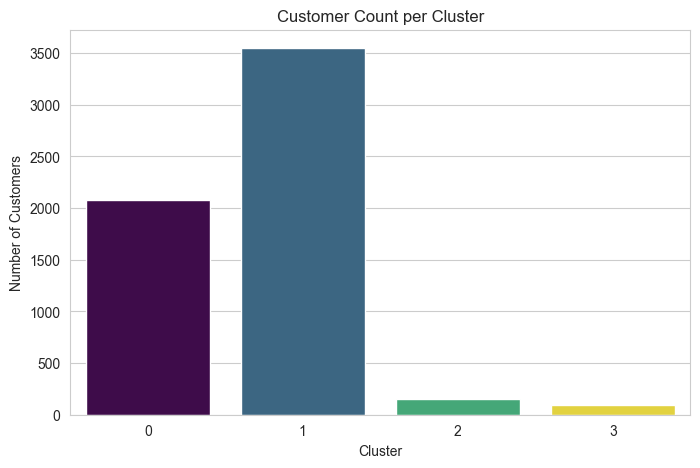

In [39]:
cluster_counts = df_final['Cluster'].value_counts().sort_index()
print("Cluster Counts:")
print(cluster_counts)

plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, hue=cluster_counts.index, palette='viridis', legend=False)
plt.title('Customer Count per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

## 3. Descriptive Statistics per Cluster

I compute the mean values for the key RFM metrics as well as derived efficiency indicators to better compare the profiles of each cluster.  
This table helps quickly identify differences in customer recency, purchasing intensity, spending patterns, and product diversity.

**Metrics included:**
- **Recency**: number of days since last purchase (lower = better)
- **Frequency**: number of transactions
- **Monetary**: total amount spent
- **AvgBasketValue**: mean order value
- **DistinctProducts**: product diversity
- **Revenue_per_Product**: Monetary / DistinctProducts
- **Revenue_per_Order**: Monetary / Frequency
- **Frequency_per_Product**: Frequency / DistinctProducts

The table highlights high (red) and low (blue) values to visually compare clusters.

In [40]:
# Key metrics to analyze
metrics = ['Recency', 'Frequency', 'Monetary', 'AvgBasketValue', 'DistinctProducts']

# Adding Derived RFM+ Metrics 
df_final['Revenue_per_Product'] = df_final['Monetary'] / df_final['DistinctProducts']
df_final['Revenue_per_Order'] = df_final['Monetary'] / df_final['Frequency'].replace(0, np.nan)
df_final['Frequency_per_Product'] = df_final['Frequency'] / df_final['DistinctProducts']

metrics += ['Revenue_per_Product', 'Revenue_per_Order', 'Frequency_per_Product']

# Groupby Mean
cluster_means = df_final.groupby('Cluster')[metrics].mean()
display(cluster_means.style.background_gradient(cmap='coolwarm', axis=0).format("{:.2f}"))

,Recency,Frequency,Monetary,AvgBasketValue,DistinctProducts,Revenue_per_Product,Revenue_per_Order,Frequency_per_Product
Cluster,,,,,,,,
0,446.09,2.20,933.18,400.83,35.46,111.49,400.83,0.17
1,61.32,8.68,4097.32,365.32,109.12,55.21,365.32,0.16
2,164.30,6.33,3562.02,578.14,84.30,51.27,578.14,0.11
3,127.04,6.48,3674.81,475.23,84.21,56.47,475.23,0.11


This highlights clear differences between clusters:

- **Cluster 1** stands out with the **highest Frequency and Monetary values**, confirming it as the most valuable customer group.
- **Cluster 0** shows **very high Recency and low spending**, indicating long-inactive or low-value customers.
- **Clusters 2 and 3** exhibit **high Monetary value but lower Frequency**, pointing to occasional big spenders or niche customer groups.
- The derived metrics (Revenue_per_Product, Revenue_per_Order) further reinforce these contrasts and help identify spending patterns more precisely.

---

### 3.1 Feature Distributions

Visualizing the distributions helps us see the spread and overlap between clusters.

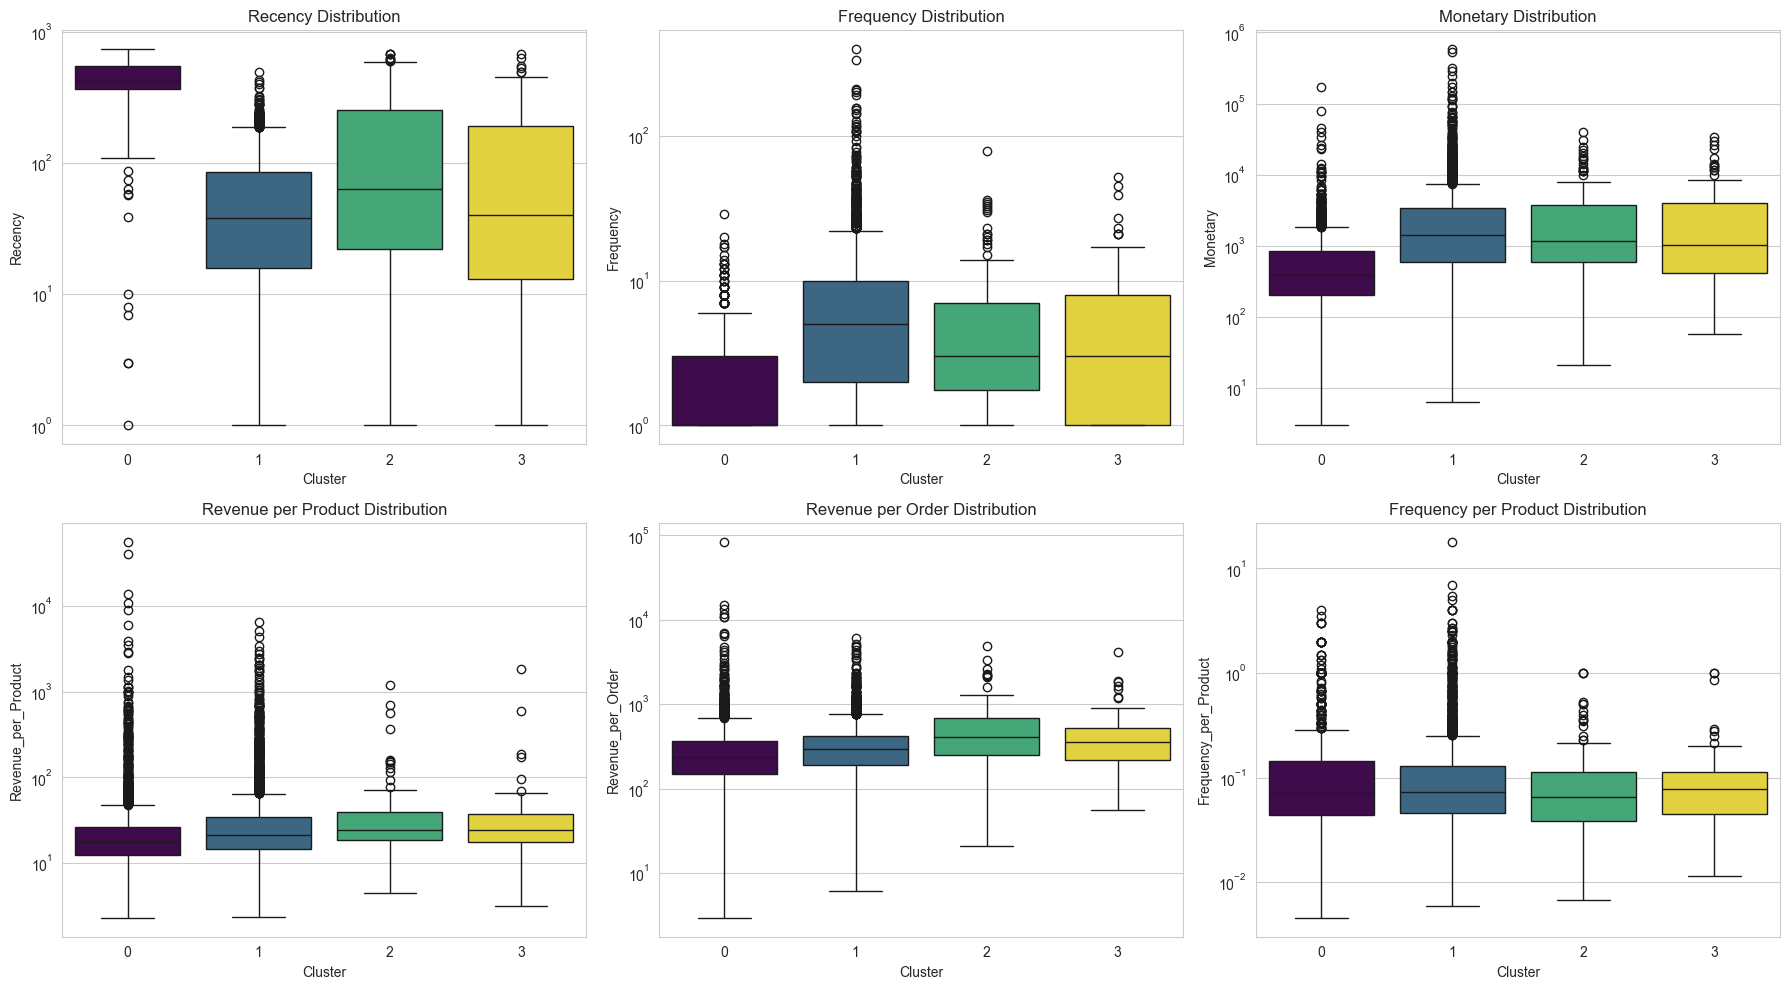

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

plots = [
    ('Recency', 'Recency Distribution'),
    ('Frequency', 'Frequency Distribution'),
    ('Monetary', 'Monetary Distribution'),
    ('Revenue_per_Product', 'Revenue per Product Distribution'),
    ('Revenue_per_Order', 'Revenue per Order Distribution'),
    ('Frequency_per_Product', 'Frequency per Product Distribution'),
]

for i, (metric, title) in enumerate(plots):
    sns.boxplot(
    data=df_final,
    x='Cluster',
    y=metric,
    hue='Cluster',
    palette='viridis',
    dodge=False,
    legend=False,
    ax=axes[i]
)
    axes[i].set_title(title)
    axes[i].set_yscale('log')  # log scale

plt.tight_layout()
save_fig('boxplots_rfm+')
plt.show()

The boxplots give a visual confirmation of the behavioral differences already observed across clusters:

- **Cluster 0** shows **very high Recency** and **very low spend/frequency**, matching a dormant or inactive segment.
- **Cluster 1** consistently sits **highest on Frequency, Monetary, and Revenue metrics**, confirming it as the most valuable and engaged segment.
- **Clusters 2 and 3** fall in the middle with **solid spending but different patterns**:
  - Cluster 2 leans toward **higher spend per product**.
  - Cluster 3 shows **higher spend per order**.
  
Overall, the distributions clearly reinforce the segmentation:  
**Cluster 1 = core loyal base**,  
**Cluster 0 = inactive customers**,  
**Cluster 2 & 3 = promising but varied profiles**.

---

## 4. Statistical Tests

I perform the Kruskal-Wallis H-test to statistically confirm that the clusters have significantly different distributions for the RFM variables.

- **stat**: the Kruskal-Wallis test statistic, higher values mean stronger differences between clusters.  
- **p_value**: probability that the differences are due to chance, if < 0.05, the differences are statistically significant.

In [42]:
for metric in ['Recency', 'Frequency', 'Monetary']:
    groups = [df_final[df_final['Cluster'] == c][metric] for c in sorted(df_final['Cluster'].unique())]
    stat, p_value = kruskal(*groups)
    print(f"Kruskal-Wallis test for {metric}: Statistic={stat:.2f}, p-value={(p_value):.2e}")
    if p_value < 0.05:
        print(f"Significant difference found for {metric}.\n")
    else:
        print(f"No significant difference found for {metric}.\n")

Kruskal-Wallis test for Recency: Statistic=3853.77, p-value=0.00e+00
Significant difference found for Recency.

Kruskal-Wallis test for Frequency: Statistic=1447.28, p-value=0.00e+00
Significant difference found for Frequency.

Kruskal-Wallis test for Monetary: Statistic=1154.23, p-value=6.24e-250
Significant difference found for Monetary.



These results show **highly significant differences (p < 0.0001)** for all three RFM variables:
- **Recency**
- **Frequency**
- **Monetary**

This means that the distributions of these metrics are **not the same across clusters**.  
Each cluster behaves differently in terms of purchase recency, transaction frequency, and spending level.

In summary: **the clusters are statistically distinct and the segmentation is meaningful.**

---

## 5. Visual Comparative Profiles

To better visualize the "shape" of each cluster, we normalize the data and plot a heatmap and a parallel coordinates plot (Snake Plot). We will interpret each visualization to understand the distinct characteristics of our segments.

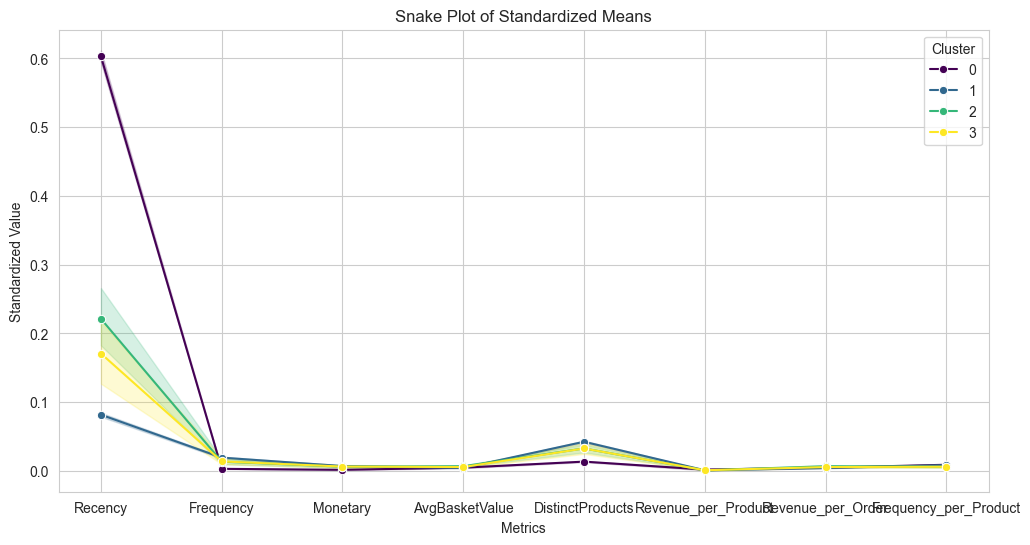

In [47]:
# Normalize data for visualization (Min-Max scaling for plot)
df_norm = df_final.copy()
for col in metrics:
    df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())

# Melt for Snake Plot
df_melt = pd.melt(df_norm.reset_index(), 
                  id_vars=['CustomerID', 'Cluster'], 
                  value_vars=metrics, 
                  var_name='Metric', 
                  value_name='Value')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melt, x='Metric', y='Value', hue='Cluster', palette='viridis', marker='o')
plt.title('Snake Plot of Standardized Means')
plt.xlabel('Metrics')
plt.ylabel('Standardized Value')
plt.legend(title='Cluster')
plt.show()

This plot standardizes the metrics to compare the "shape" of each cluster:
- **Cluster 0 (Purple)**: Characterized by **very high Recency** (standardized value ~0.6) and near-zero values for Frequency and Monetary. These are clearly inactive or lost customers.
- **Cluster 1 (Blue)**: Shows low Recency and moderate to high values on other metrics.
- **Cluster 2 (Green) & Cluster 3 (Yellow)**: Show similar profiles with low Recency. Their differences are subtle here and will be clearer in the heatmaps.

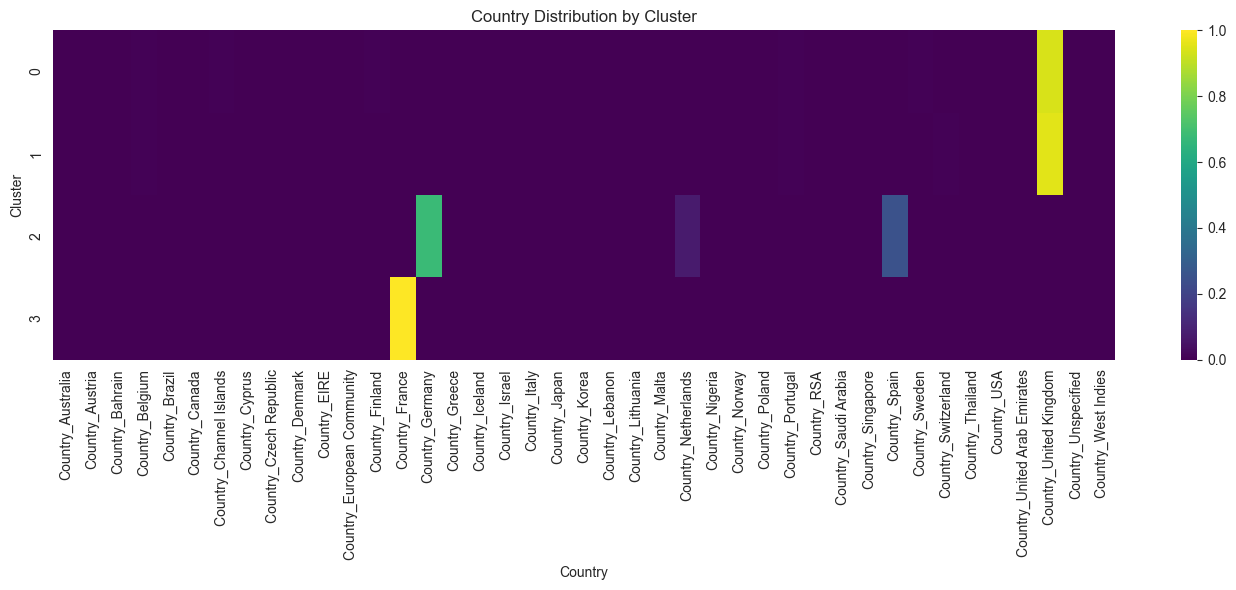

In [44]:
# Country Distribution Heatmap 
country_cols = [col for col in df_final.columns if col.startswith("Country_")]

country_cluster = df_final.groupby("Cluster")[country_cols].mean()

plt.figure(figsize=(14, 6))
sns.heatmap(country_cluster, cmap="viridis", annot=False)
plt.title("Country Distribution by Cluster")
plt.xlabel("Country")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

- **Cluster 0 & 1**: Are predominantly composed of customers from the **United Kingdom**.
- **Cluster 2**: Is the most **international** cluster, with a strong presence in **Germany, Netherlands, and Spain**. This is a key segment for European expansion.
- **Cluster 3**: Appears to be highly concentrated in **France**.

This geographic distinction is crucial: Cluster 2 might require specific logistics and marketing strategies adapted for export.

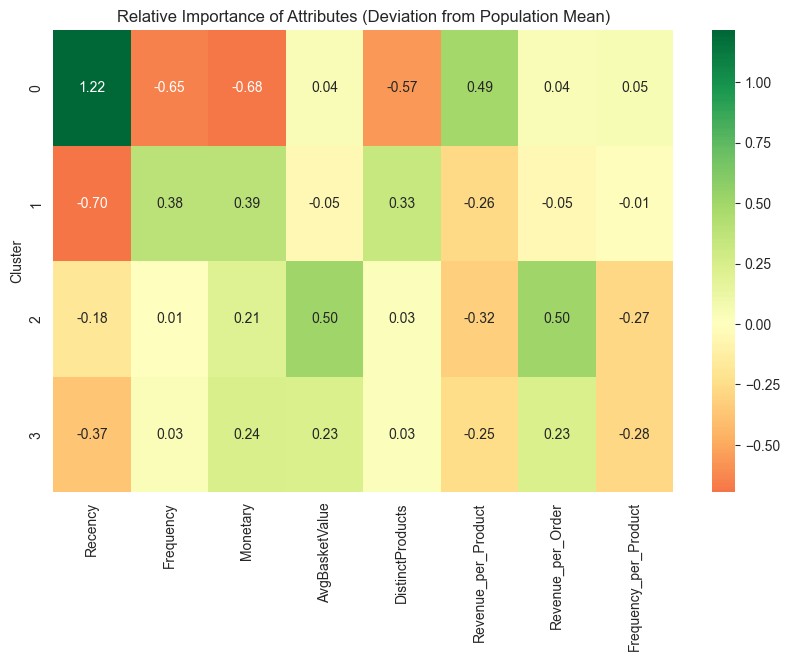

In [45]:
# Relative Importance Heatmap
# Calculate relative importance: Cluster Mean / Population Mean - 1
population_avg = df_final[metrics].mean()
cluster_avg = df_final.groupby('Cluster')[metrics].mean()
relative_imp = cluster_avg / population_avg - 1

plt.figure(figsize=(10, 6))
sns.heatmap(relative_imp, annot=True, fmt='.2f', cmap='RdYlGn', center=0)
plt.title('Relative Importance of Attributes (Deviation from Population Mean)')
plt.show()

This heatmap is the most insightful as it shows the deviation from the population mean:
- **Cluster 0 (Inactive)**: **Recency +122% (very poor), Frequency -65%, Monetary -68%. These customers weigh down the database without generating recent value.
- **Cluster 1 (Champions)**: Frequency +38%, Monetary +39%, and Recency -70% (very good). These are the most active and loyal customers.
- **Cluster 2 (Big Spenders / International)**: Distinguishes itself with an AvgBasketValue of +50% and Revenue per Order of +50%. They buy less often (Frequency near average) but spend significantly more per transaction.
- **Cluster 3 (Regulars / France)**: A balanced profile with Global Monetary value +24% and good Recency (-37%). A solid mid-tier segment.

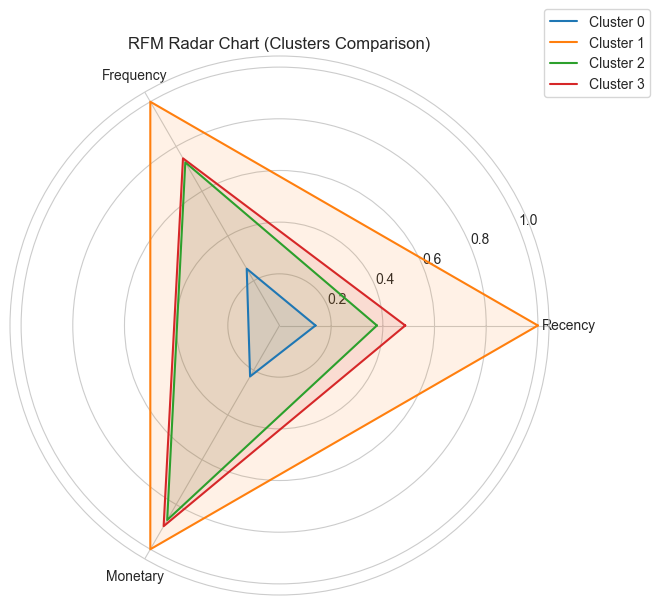

In [46]:
# RFM Radar Chart 
rfm_cols = ['Recency', 'Frequency', 'Monetary']

df_radar = df_final.groupby('Cluster')[rfm_cols].mean().copy()

# Create a normalized dataframe for plotting
df_radar_norm = df_radar.copy()

# Invert Recency (1/x) so higher is better
# We add a small epsilon to avoid division by zero if Recency is 0
df_radar_norm['Recency'] = 1 / (df_radar_norm['Recency'] + 1)

# Normalize by Max to keep the ratio (0-1 scale relative to best performer)
# This prevents the lowest performer from being set to 0, which can be misleading
for col in rfm_cols:
    df_radar_norm[col] = df_radar_norm[col] / df_radar_norm[col].max()

# Radar plotting
labels = rfm_cols
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

for cluster in df_radar_norm.index:
    values = df_radar_norm.loc[cluster].tolist()
    values += values[:1]
    ax.plot(angles, values, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title("RFM Radar Chart (Clusters Comparison)")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()


The radar chart confirms the RFM segmentation:
- **Cluster 1 (Orange)**: Covers the largest area, excelling in **Frequency and Monetary**, with very good Recency (high inverted Recency). This is the ideal profile.
- **Cluster 2 (Green) & 3 (Red)**: Have similar shapes, performing well in Recency and Monetary, but less so in Frequency compared to Cluster 1.
- **Cluster 0 (Blue)**: Is very retracted towards the center for Frequency and Monetary, and its spike towards Recency is low (since high actual Recency = low inverted Recency). This is the profile to reactivate or deprioritize.

---

## 6. Cluster Profiling / Personas

Based on the statistical analysis and visualizations, we can define the following personas:

#### **Cluster 0: "Dormant / Low Value"**
- **Characteristics**: High Recency (haven't bought in a long time). Low Frequency and low Monetary value.
- **Insight**: These are likely churned or one-time customers.
- **Action**: Re-engagement campaigns are difficult but low cost (email). Focus on winning back only those with higher past value if possible, otherwise deprioritize.

#### **Cluster 1: "Loyal Champions"**
- **Characteristics**: Low Recency (bought recently), High Frequency and high Monetary value.
- **Insight**: These are your best customers. They buy often and spend the most.
- **Action**: Retention is key. Offer VIP programs, early access to new products, and loyalty rewards to keep them engaged.

#### **Cluster 2: Internationals Whales**
- **Characteristics**: High Monetary value driven by a very high Average Basket Value. International footprint (Germany, Netherlands, Spain, France). Good Recency.
- **Insight**: These are likely B2B clients or bulk buyers based in Europe. They order less frequently than Champions but spend significantly more per transaction.
- **Action**: Logistics & Account Management. Ensure smooth cross-border shipping. Offer bulk discounts or dedicated account support.

#### **Cluster 3: French Regulars**
- **Characteristics**: Good Recency and Monetary value, but lower Frequency than Champions. Predominantly located in France.
- **Insight**: Solid active customer base in the domestic market. They are reliable but have room to grow in frequency or basket size.
- **Action**: Use localized French marketing campaigns to encourage more frequent purchases or recommend complementary products to increase their basket size.

---

## 7. Export Profiles

We export the summary statistics and the full customer list with cluster assignments for downstream usage.

In [48]:
# Export Cluster Profiles
profile_path = PROCESSED_DIR / 'cluster_profiles.csv'
cluster_means.to_csv(profile_path)
print(f"Saved cluster profiles to {profile_path}")

# Export Customers with Clusters
customers_path = PROCESSED_DIR / 'customers_with_clusters.csv'
df_final.to_csv(customers_path, index=False)
print(f"Saved customers with clusters to {customers_path}")

Saved cluster profiles to ..\data\processed\cluster_profiles.csv
Saved customers with clusters to ..\data\processed\customers_with_clusters.csv


## 8. Final Conclusion

We have successfully segmented the customer base into distinct groups:

1.  **Loyal Champions** drive the majority of revenue and should be protected.
2.  **Dormant Customers** represent a large portion of the base but contribute little value, automated re-engagement is the best strategy.
3.  **High Potential** segments offer the best opportunity for growth through targeted up-selling and cross-selling.

This segmentation provides a data-driven foundation for marketing strategies and customer relationship management.